# Research Question 6 - Newspaper Analysis

---

### What this Notebook contains

1. **Data Setup**

	- We seek to investigate what are some main characteristics of people that have been quoted speaking about the environment between 2018 and 2020 for specific news sources.

	<br/>
	
	- The data used for the analysis in this notebook is based on the quotes between 2018 and 2020. After having applied our topic labeling to the quotes each year, we used the Wikidata as previously done to extract features of the speakers that correspond to a given quote.

	<br/>
	
	- As one quote might have multiple QID's, we exploded those such that assume each speaker said the given quote (as done for research question @Stephane)

<br/>

2. **News Source Specific Analysis**

	2.1. In the first part we split the data frame by newspaper sources, choosing the top 10 news paper sources that have been quoting the most.

	2.2. We then investigate a bit more in depth the relation between the political party and frequencies of environmental quotes in the top 10 news sources.

	2.3. Further, the attribute occupation is investigated and differences and similarities between news sources are highlighted with respect to the top 10 occupations present.

	2.4. Lastly, the age distribution for each news source of the top 10 is plotted and analyzed.

<br/>

3. **Logistic Regression** 

	3.1. To gain deeper insights on the effect that a given feature has (e.g. age) on the probability of being quoted about the environment by a given news source, we perform a logistic regression.

	3.2. We pick as an outcome 1 if someone has been quoted by the news source breitbart, which is considered to be a right-winged news magazine from the US (https://de.wikipedia.org/wiki/Breitbart_News_Network) vs the science-based liberal source eurekalert sponsored by the American Association for the Advancement of Science.  We investigate whether the age, being in the democratic party and being a researcher or journalist (two occupations that are known for being reglularly under attack from people from the right and far-right political spectrum) increases ones chanced of being quoted about the environment by breitbart.

---

In [95]:
# importing needed packages

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import math
from tld import get_tld
import seaborn as sns
import processing as pr
import statsmodels.formula.api as smf

In [96]:
# setting relevant paths to the data which can be found in the data folder
root = os.getcwd()
path_output = root + '/data/output'
path_speakers = path_output + '/speakers_labeled/environment_speakers_2018-2020.parquet.gzip'

---

## 1. Data Setup and Initial Cleaning

In [97]:
# Loading the data

env_feature = pd.read_parquet(path_speakers)
env_feature.shape

(485198, 25)

### 1.1. Filtering News Sources
We first get rid of columns that are not of any interest to us. We want to keep gender, occupation, political party, age, academic degree and the domain

In [ ]:
env_features = env_feature[['gender', 'occupation', 'party', 'academic_degree', 'age', 'speaker', 'domains']]
env_features['domains'] = env_features['domains'].apply(np.unique)
env_features['domains'] = [env_features['domains'][i][0] for i in range(env_features.shape[0])]
env_features['party'] = [env_features['party'][i][0] for i in range(env_features.shape[0])]
env_features['academic_degree'] = [env_features['academic_degree'][i][0] for i in range(env_features.shape[0])]
env_features.head(3)

We now only keep the top 10 news sources

In [99]:
news_domains = env_features['domains']
count_news_sources = news_domains.value_counts()
top_news_sources = count_news_sources[0:10]
top_news_sources

breitbart        5566
eurekalert       5402
miragenews       4951
carbonbrief      4766
benzinga         4755
msn              4460
nzcity           4092
brisbanetimes    4065
scoop            3914
stuff            3462
Name: domains, dtype: int64

---

## 2. News Source Specific Analysis

### 2.1 General Overview

Now we first want to get an idea how 'representative these news sources are in the sense that we want to find out for how many of the quotes they are responsible.

In [100]:
sum_all_news_sources = count_news_sources.sum()
top_news_proportions = (top_news_sources.values/sum_all_news_sources)*100

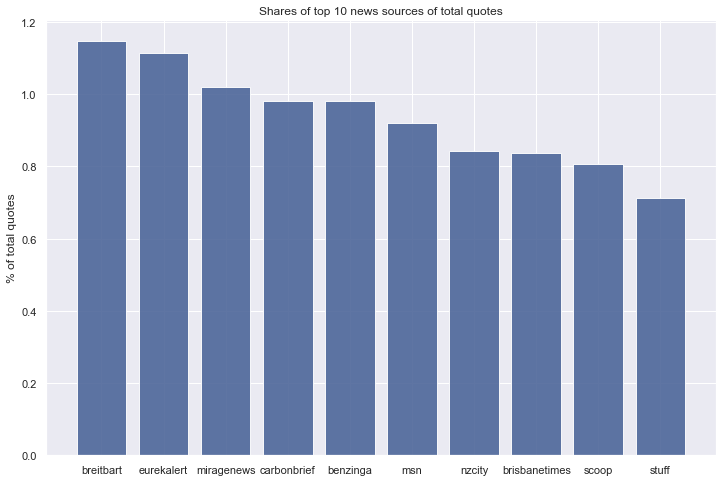

In [101]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)
x_labels = top_news_sources.index
x_steps = np.arange(top_news_sources.shape[0])
plt.bar(x_steps,top_news_proportions,align='center', alpha=0.9,color=(0.3, 0.4, 0.6,0.4))
plt.xticks(x_steps,x_labels)
plt.ylabel('% of total quotes')
plt.title('Shares of top 10 news sources of total quotes')
plt.show()

What we is a clear message: there is not *the one* news source that dominates all of them. Their share ranges between around 0.7% for stuff to 1.15% for breitbart. Although it is a significant difference, their order of mganitude is about the same. 

---

### 2.2. Political Parties between News Sources

Let us first check what the top political parties are for the entire data set.

In [102]:
party = env_features['party']
count_parties = party.value_counts()
top_parties = count_parties[0:10]
top_parties

Democratic Party                24287
Republican Party                13776
Labour Party                     3603
Conservative Party               3299
Liberal Party of Australia       2878
Liberal Party of Canada          2751
Australian Labor Party           2658
Bharatiya Janata Party           2141
Socialist Party                  1490
Conservative Party of Canada     1211
Name: party, dtype: int64

Let's see how these parties are present within the different news sources.

In [103]:
env_features_bynews = env_features[env_features['domains'].isin(top_news_sources.index)]
env_features_bynews.head(3)

,gender,occupation,party,academic_degree,age,speaker,domains
quoteID,,,,,,,
2019-11-17-006664,[male],"[singer, singer-songwriter, film director, mus...",None,None,76.0,Neil Young,breitbart
2018-05-06-022868,[female],"[film actor, stage actor, television actor, vo...",Democratic Party,None,72.0,Meryl Streep,msn
2018-06-08-052618,[male],"[politician, historian]",Civic Platform,None,64.0,Donald Tusk,breitbart


We want to visualize the proportions that the parties have for each news source. To do so, we firs normalize by dividing the propotions that the top 10 news have by their sum. This means what are the proportions of each news source among the top 10 news sources and their quotes. We then collect the political parties for proportions less than 5% by 'Others'.

In [104]:
def compute_prop(feature,val,news,data):
	"""
	Function returns the proportions that a feature has for a specific news paper

	Input:
		feature is the attribute like occupation
		value is the current value of the feature like researcher
		news is the news source to be considered like msn
		data is the data to be used

	Output:
		the proportion that the current value of the feature has for the given news source among all news
		sources for the given feature
	"""

	data_news = data[data['domains'] == news]
	data_news_par = data_news[data_news[feature]== val]
	prop = data_news_par.shape[0]/data_news.shape[0]
	return prop

In [105]:
proportions_news_party = pd.DataFrame(index= top_news_sources.index,columns=top_parties.index)

for i in range(10):
	curr_news = top_news_sources.index[i] # the news source to be considered

	for j in range(10):
		curr_party = top_parties.index[j] # the party to be considered
		curr_prop = compute_prop('party',curr_party,curr_news,env_features_bynews)
		proportions_news_party.iloc[i,j] = curr_prop

In [106]:
# let us normalize the proportions to make them sum to 1

row_sums = np.sum(proportions_news_party,axis=1).values
prop_news_party = proportions_news_party.div(row_sums,axis=0)

In [107]:
others = []
for i in range(prop_news_party.shape[0]):
	below_5percent = np.where(prop_news_party.iloc[i,:] < 0.05)[0]
	props_below5percent = prop_news_party.iloc[i,below_5percent]
	others.append(np.sum(props_below5percent.values))

prop_news_party['Others'] = others
prop_news_party

,Democratic Party,Republican Party,Labour Party,Conservative Party,Liberal Party of Australia,Liberal Party of Canada,Australian Labor Party,Bharatiya Janata Party,Socialist Party,Conservative Party of Canada,Others
breitbart,0.592634,0.223214,0.033482,0.020089,0.018973,0.032366,0.018973,0.001116,0.05692,0.002232,0.127232
eurekalert,0.293578,0.330275,0.100917,0.082569,0.018349,0.018349,0.119266,0.027523,0.009174,0.0,0.073394
miragenews,0.071101,0.094037,0.020642,0.022936,0.077982,0.34633,0.350917,0.0,0.006881,0.009174,0.059633
carbonbrief,0.24,0.148571,0.179048,0.310476,0.047619,0.017143,0.019048,0.0,0.032381,0.005714,0.121905
benzinga,0.280654,0.26703,0.043597,0.046322,0.010899,0.307902,0.032698,0.002725,0.002725,0.00545,0.144414
msn,0.358095,0.175238,0.051429,0.049524,0.228571,0.00381,0.102857,0.001905,0.022857,0.005714,0.083810
nzcity,0.318841,0.253623,0.07971,0.086957,0.072464,0.0,0.108696,0.0,0.07971,0.0,0.000000
brisbanetimes,0.072148,0.080537,0.021812,0.035235,0.432886,0.0,0.347315,0.0,0.010067,0.0,0.067114
scoop,0.300813,0.357724,0.04065,0.03252,0.04878,0.01626,0.186992,0.0,0.01626,0.0,0.154472
stuff,0.309278,0.340206,0.123711,0.051546,0.061856,0.0,0.072165,0.0,0.020619,0.020619,0.041237


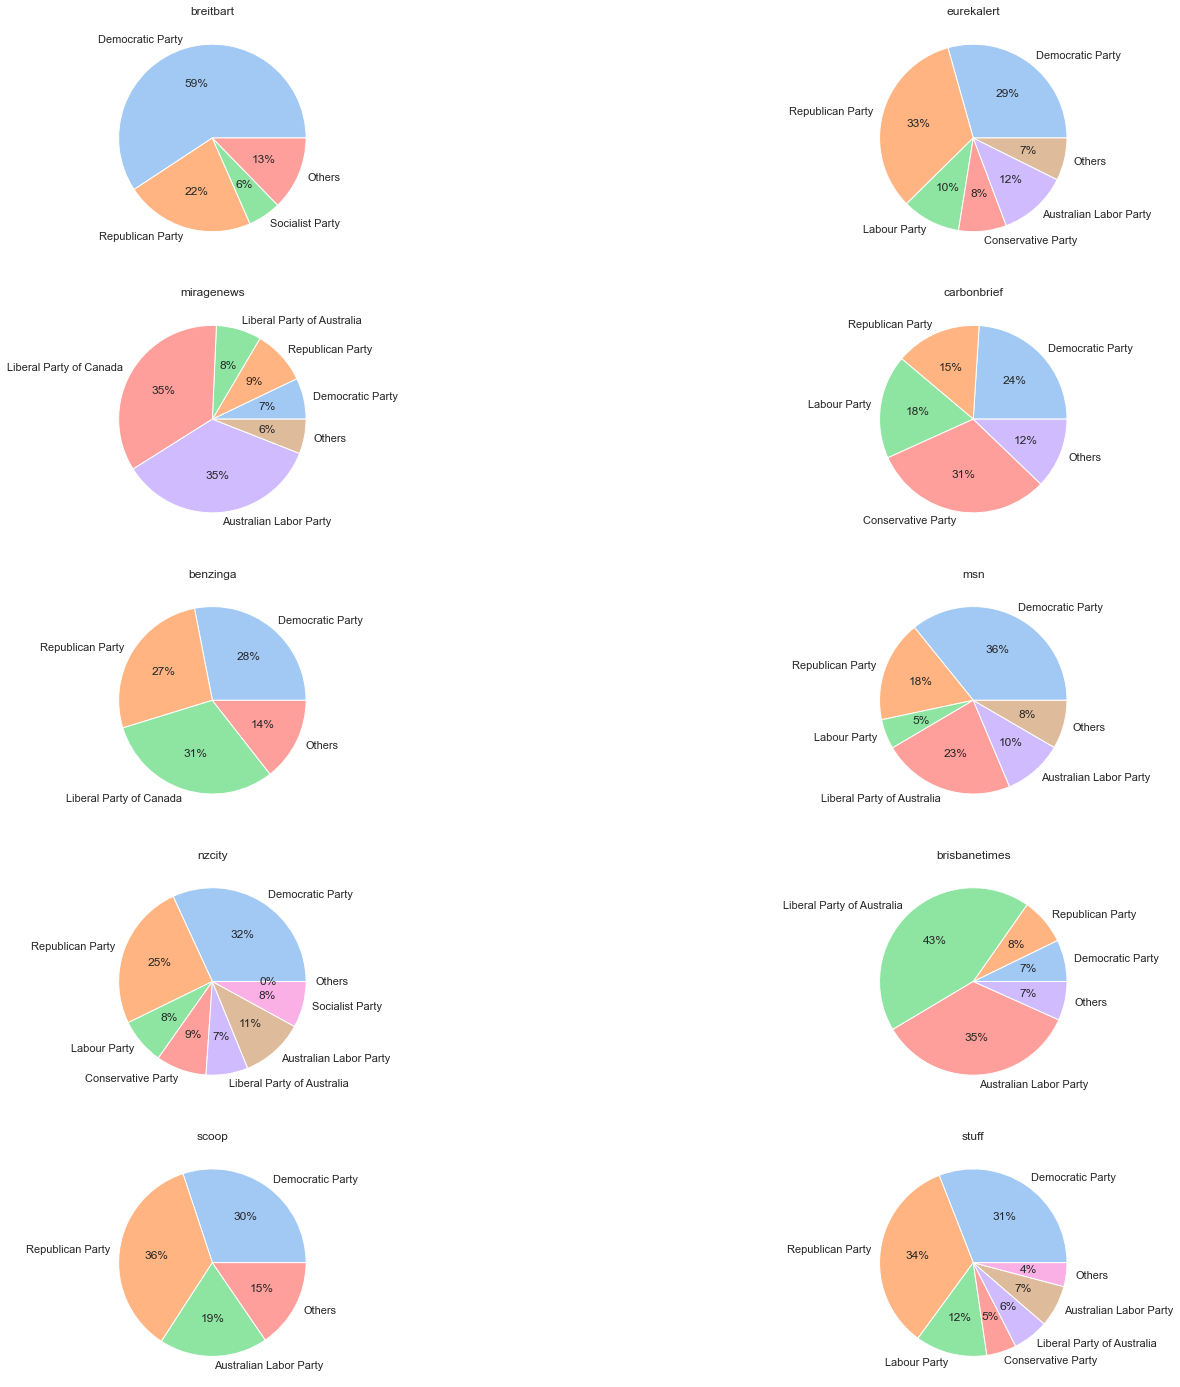

In [108]:
fig, ax = plt.subplots(5,2,figsize= (25,25), sharey = True, sharex = True)
all_labels = prop_news_party.columns

for i in range(10):
    curr_props = prop_news_party.iloc[i,:]
    curr_above5percent = np.where(curr_props[:-1] >= 0.05)[0] # the index of the parties who individually have > 0.03
    curr_above5percent = np.append(curr_above5percent,-1)
    labels = all_labels[curr_above5percent]
    curr_props_above5 = curr_props[curr_above5percent]
    curr_title = prop_news_party.index[i]
    sbplt = ax[math.floor(i/2),i%2] # this sets the subplot we want to fill
    colors = sns.color_palette('pastel')[0:len(labels)]
    sbplt.pie(curr_props_above5.values,labels = labels,colors = colors,autopct='%.0f%%',normalize=True)
    sbplt.set_title(curr_title)

### Interpretation

A few things are worth pointing out. First we see that, as one might expect the two big US American parties are present in all news sources. It is, however also interesting to see that in particular the *Astralian Labor Party*, *Liberal Party of Australia* and the *Liberal Party of Canada* are also fairly often present. For example in stuff the first two have shares of 7% and 6% respectively. Given that stuff is a news magazine from New Zealand this is reasonable. It is then even more surprising that the Republican and Democratic party have such high shares.

A few frequencies are particularly interesting. For breitbart, a right-winged news magazine from the US 59% of the quotes about the environment among the quotes of all top 10 news sources are given by people from the Democratic Party. This seems counterintuitive at first sight, but more on that later. Also msn has a rahter high share with almost 36%.

---

### 2.3. Occupation between News Sourcres

Now we turn to the occupation. The issue that we face here is that a single speaker might have multiple occupations. For example, Obama is a lawyer and politician and Wikidata might have both. We deal with that by exploding this feature.

In [109]:
env_features_byocc = env_features[env_features['domains'].isin(top_news_sources.index)]
env_features_exploded_byocc = env_features.explode('occupation')
env_features_exploded_byocc = env_features_exploded_byocc[['occupation','domains']].dropna()

In [110]:
env_features_exploded_byocc.shape

(788513, 2)

Now we filter out the most frequent occupations, again restricting ourselves to the top 10

In [111]:
occ = env_features_exploded_byocc['occupation']
count_occ = occ.value_counts()
top_occ = count_occ[0:10]
top_occ

politician                     98735
researcher                     41340
association football player    28286
writer                         23924
actor                          21405
lawyer                         21178
journalist                     16537
American football player       15242
businessperson                 15162
university teacher             12799
Name: occupation, dtype: int64

We see that there is one entry 'association football player' and 'American football player', which we will merge into one category 'football player' later.

In [112]:
proportions_news_occ = pd.DataFrame(index= top_news_sources.index,columns=top_occ.index)

for i in range(10):
	curr_news = top_news_sources.index[i] # the news source to be considered

	for j in range(10):
		curr_occ = top_occ.index[j] # the party to be considered
		curr_prop = compute_prop('occupation',curr_occ,curr_news,env_features_exploded_byocc)
		proportions_news_occ.iloc[i,j] = curr_prop

Let us merge the two different football player types into one

In [113]:
proportions_news_occ['football player'] = np.array(proportions_news_occ['association football player'].values) + np.array(proportions_news_occ['American football player'].values)
proportions_news_occ.drop(columns=['association football player','American football player'],inplace=True)

In [114]:
prop_news_occ = proportions_news_occ.div(proportions_news_occ.sum(axis=0), axis=1)

In [115]:
prop_news_occ

,politician,researcher,writer,actor,lawyer,journalist,businessperson,university teacher,football player
breitbart,0.10095,0.06091,0.16818,0.117971,0.18587,0.135481,0.125249,0.169455,0.045018
eurekalert,0.033329,0.31666,0.059227,0.08043,0.043928,0.056951,0.051102,0.165392,0.089224
miragenews,0.144683,0.169325,0.06462,0.07933,0.119903,0.049927,0.085195,0.07512,0.084666
carbonbrief,0.08193,0.068719,0.193741,0.124004,0.067548,0.231624,0.107999,0.151834,0.067126
benzinga,0.076106,0.067111,0.095075,0.120632,0.104656,0.086464,0.211745,0.068764,0.142058
msn,0.089793,0.06275,0.111392,0.121336,0.147055,0.117425,0.136088,0.107197,0.080661
nzcity,0.116815,0.075713,0.063184,0.072862,0.046641,0.054111,0.052883,0.067722,0.134587
brisbanetimes,0.154874,0.044524,0.102657,0.091659,0.169119,0.132948,0.099646,0.061156,0.076373
scoop,0.106192,0.063192,0.07453,0.085738,0.068758,0.038215,0.048015,0.083916,0.140352
stuff,0.095328,0.071097,0.067395,0.106038,0.046521,0.096855,0.082079,0.049443,0.139936


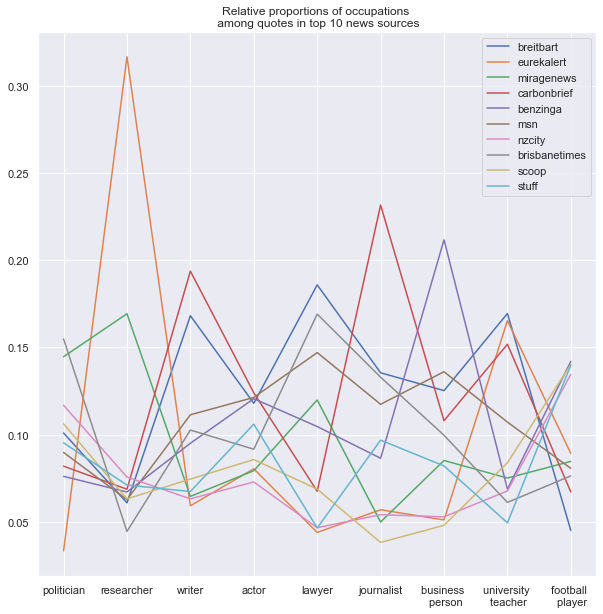

In [116]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
y_ticks = ['politician','researcher','writer','actor','lawyer','journalist','business \n person','university \n teacher','football \n player']
for i in range(10):
	curr_props = prop_news_occ.iloc[i,]
	curr_news = prop_news_occ.index[i]
	x_ticks = np.arange(1,11)
	plt.plot(y_ticks,curr_props,label=curr_news)
plt.legend()
plt.title('Relative proportions of occupations \n among quotes in top 10 news sources')
plt.show()


### Interpretation

The plot above might seem chaotic at first sight, but reveals some interesting things about the diversity of jobs within a given news paper source. For example, we see that the job *politician* is almost equally present in all news sources when it comes to the top occupations among all environmentally related quotes. For the job *researcher* on the other hand, eurekalert seems to cite poeple whose job is researcher talking about the environment much more often. Similar pattern can be observed for actor and journalist, respectively.

---

### 2.4. Age between News Sources

In the next step we want to analyze the age distribution among the speakers that have been quoted about the environment in the top 10 news sources.

In [117]:
env_features_byage = env_features[env_features['domains'].isin(top_news_sources.index)]
env_features_byage = env_features_byage[['age','domains']].dropna()
env_features_byage

,age,domains
quoteID,,
2019-11-17-006664,76.0,breitbart
2018-05-06-022868,72.0,msn
2018-06-08-052618,64.0,breitbart
2019-08-24-049549,64.0,breitbart
2018-01-23-017333,71.0,msn
...,...,...
2019-04-15-091622,67.0,eurekalert
2019-11-18-007304,46.0,breitbart
2020-02-03-053466,88.0,eurekalert


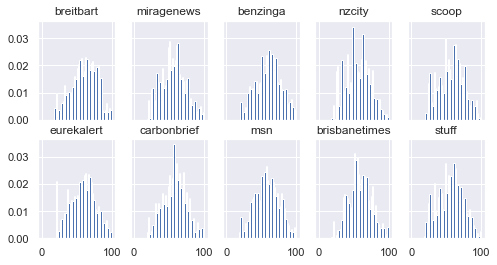

In [118]:
fig, ax = plt.subplots(2,5,figsize= (8,4), sharey = True, sharex = True)
sns.set()
for i in range(10):
	curr_news = top_news_sources.index[i]
	curr_ages = env_features_byage[env_features_byage['domains'] == curr_news]['age'].values
	curr_title = prop_news_party.index[i]
	sbplt = ax[i%2,math.floor(i/2)] # this sets the subplot we want to fill
	sbplt.hist(curr_ages,bins = 50,density=True,range = [0,100])
	sbplt.set_title(curr_title)

What we can observe, is that overall all news sources seem to have a similar age distribution for the speakers that have been quoted about the environment. A few things stick out.

- First it should be noted that we cut off the extreme right tail. Hence, people older than 100 years are not present in these plots. Therefore, ancient greek mathematicians and other historic personalities are not reflected here.

<br/>

- For eurekalert, there is a significant portion of the probability mass at the lower end, hence it quotes people about the environment that seem to be rather young. A similar pattern is observed for nzcity, scoop and miragenews, although not as strong.

<br/>

- scoop and brisbanetimes have a slimmer and more peaky density compared to the rest  


---

## 3. Regression Analysis

We now use a logistic regression to infer which characteristics are crucial to be cited by the news magazine breitbart. After some quick research we found that breitbart is considered to be an extreme right-winged news magazine from the US (https://de.wikipedia.org/wiki/Breitbart_News_Network). This clearly allows for an initial guess what the main characeristics are. On the one hand, keeping in mind the recent history of the US policy in the years 2018-2020, one could argue that people like Donald Trump have been cited a lot about the environment - old, Repuclican and with very conservative and extreme views. On the other, it can also be argued that the exact opposite is the case: to demolish opposing politicians and other people with different views, these might have been quoted very frequently to attack them and their views. 

The opposite label is 0 for the science-based liberal source eurekalert sponsored by the American Association for the Advancement of Science. We investigate whether the age, being in the democratic party and being a researcher or journalist (two occupations that are known for being reglularly under attack from people from the right and far-right political spectrum) increases ones chances of being quoted about the environment by breitbart.

Let's see what is going on..

In [119]:
# we start by preparing our data and creating categorical variables as desired for the regression

env_features_reg = env_features[env_features['domains'].isin(['breitbart','eurekalert'])][['age','domains','party','occupation']].dropna()
index_democr_party = np.where(env_features_reg['party'].isin(['Democratic Party']))
label_party = np.zeros(env_features_reg.shape[0])
label_party[index_democr_party] = 1
env_features_reg['label_democr'] = label_party

index_breitbart = np.where(env_features_reg['domains'].isin(['breitbart']))
label_breitbart = np.zeros(env_features_reg.shape[0])
label_breitbart[index_breitbart] = 1
env_features_reg['label_breitbart'] = label_breitbart

env_features_reg['age_stand'] = (env_features_reg['age'].values - np.mean(env_features_reg['age'].values)) / np.std(env_features_reg['age'].values)

occup_reg = env_features_reg['occupation']
index_occup = []
for i in range(occup_reg.shape[0]):
	if 'researcher' in occup_reg[i] or 'journalist' in occup_reg[i]:
		index_occup.append(i)
label_occup = np.zeros(env_features_reg.shape[0])
label_occup[index_occup] = 1
env_features_reg['label_occup'] = label_occup

In [120]:
env_features_reg.head(3)

,age,domains,party,occupation,label_democr,label_breitbart,age_stand,label_occup
quoteID,,,,,,,,
2018-06-08-052618,64.0,breitbart,Civic Platform,"[politician, historian]",0.0,1.0,0.037691,0.0
2019-08-24-049549,64.0,breitbart,Civic Platform,"[politician, historian]",0.0,1.0,0.037691,0.0
2019-04-02-031665,71.0,eurekalert,Bharatiya Janata Party,"[politician, writer, social worker, bibliograp...",0.0,0.0,0.482092,0.0


In [121]:
mod = smf.logit(formula='label_breitbart ~  age_stand + C(label_democr) + C(label_occup)', data=env_features_reg)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.322196
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        label_breitbart   No. Observations:                 1489
Model:                          Logit   Df Residuals:                     1485
Method:                           MLE   Df Model:                            3
Date:                Thu, 16 Dec 2021   Pseudo R-squ.:                 0.05559
Time:                        20:11:11   Log-Likelihood:                -479.75
converged:                       True   LL-Null:                       -507.99
Covariance Type:            nonrobust   LLR p-value:                 3.323e-12
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1.8036      0.102     17.645      0.000       1.603      

### Interpretation

What we observe is that the coefficients for 'label_democr' and standardized age 'age_stand' are significant. However, being a journalist or researcher is not a significant feature. The coefficients imply that someone who is quoted about the environment, we multiply his or her outcome by $e^{1.0283} \approx 2.8$. This means that being in the Democratic Party significantly increases his or her chance being quoted about the environment by the right-winged newspaper 'breitbart'. It is not difficult to realize that this is not neccessarily a good thing. Hence, our initial guess that being in the Democratic Party as well as age have significant impact on ones likelihood of being quoted about the environment by breitbart.

---